# Kernels demo

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [27]:
using LinearAlgebra
include("__init__.jl")
using PyCall
SkPreprocessing = pyimport("sklearn.preprocessing")
using PyPlot
plt = pyimport("matplotlib.pyplot")
using Random
SkSVM = pyimport("sklearn.svm")

RBF_features (generic function with 1 method)

## "Other normal equations" demo

- The normal equations: $$w=(X^TX+\lambda I)^{-1}X^Ty$$
- Alternate form: $$w=X^T(XX^T+\lambda I)^{-1}y$$

Let's test this out:

In [2]:
n = 1000
d = 10
X = randn(n,d)
y = rand(n)

λ=1;

In [4]:
w1 = (X'*X + λ*Array{Int64}(I,d,d))\ (X'*y)
w1

10-element Array{Float64,1}:
  0.03184633062803163 
 -0.02604234569496713 
  0.024617575996351282
 -0.014383354285724372
 -0.013709525197413449
 -0.005962299922601739
 -0.04171102545381545 
  0.007655923021691462
 -0.010429980293493816
 -0.022603514202397496

In [5]:
w2 = X'*((X*X'+λ*Array{Int64}(I,n,n))\y)
w2

10-element Array{Float64,1}:
  0.03184633062800657 
 -0.026042345694962776
  0.0246175759963565  
 -0.014383354285717687
 -0.013709525197418415
 -0.00596229992259012 
 -0.041711025453827766
  0.007655923021687272
 -0.010429980293510166
 -0.02260351420240614 

In [7]:
allClose(w1,w2)

true

This isn't a proof but they seem to yield the same results for this randomly generated dataset.

## Number of polynomial features


In [9]:
n = 2
d = 4
p = 3

X = randn(n,d)
y = randn(n)

pf = SkPreprocessing.PolynomialFeatures(degree=p)
Z = pf.fit_transform(X)
size(Z)

(2, 35)

Above: we get $k=35$ as in the slides.

## Polynonial kernel vs. polynomial features (for regression)


In [11]:
n = 10
x = rand(n)
y = x.^2 + randn(n)*0.1;

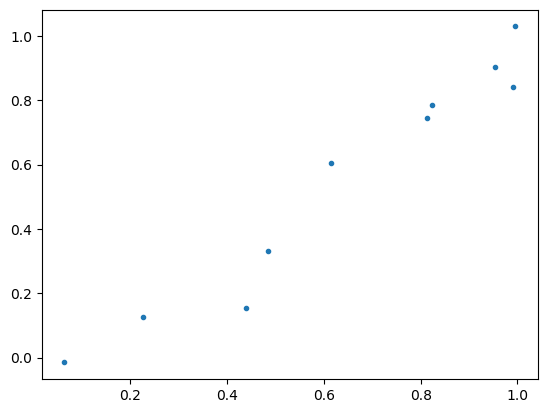

In [13]:
plt.plot(x,y,".");

In [15]:
SkKernelRidge = pyimport("sklearn.kernel_ridge")
SkLinearModel = pyimport("sklearn.linear_model")

k=10  # polynomial degree
λ=1e-10 # L2 regularization strength

X = reshape(x,length(x),1)
pf = SkPreprocessing.PolynomialFeatures(degree=k)
Z = pf.fit_transform(X)

ridge = SkLinearModel.Ridge(alpha=λ, fit_intercept=false) 
# fit_intercept=False because features already include intercept feature
# could alternatively set include_bias=False for the PolynomialFeatures
ridge.fit(Z,y)

PyObject Ridge(alpha=1e-10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

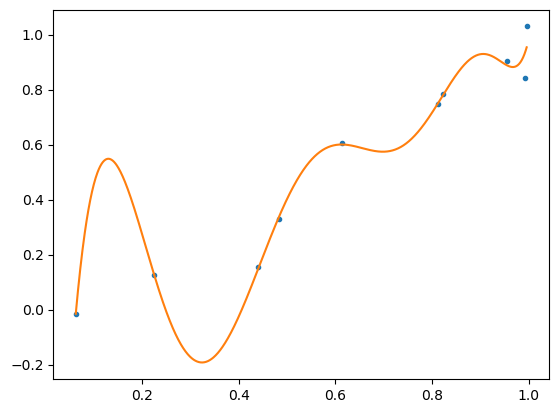

In [18]:
grid = reshape(range(minimum(x),stop=maximum(x),length=1000),1000,1)
plt.plot(x,y,".")
plt.plot(grid, ridge.predict(pf.transform(grid)));

In [19]:
ridge.coef_

11-element Array{Float64,1}:
    -2.2648086547851562
    54.46995747089386  
  -348.4217441082001   
   791.0944981575012   
  -297.8525207042694   
  -929.5056574344635   
   240.59610676765442  
  1208.8515241146088   
   150.2549387216568   
 -1670.6712690591812   
   804.4347157478333   

#### And now the same with a kernel

In [20]:
kr = SkKernelRidge.KernelRidge(alpha=λ, kernel="polynomial", degree=k)
kr.fit(X,y)

PyObject KernelRidge(alpha=1e-10, coef0=1, degree=10, gamma=None, kernel='polynomial',
            kernel_params=None)

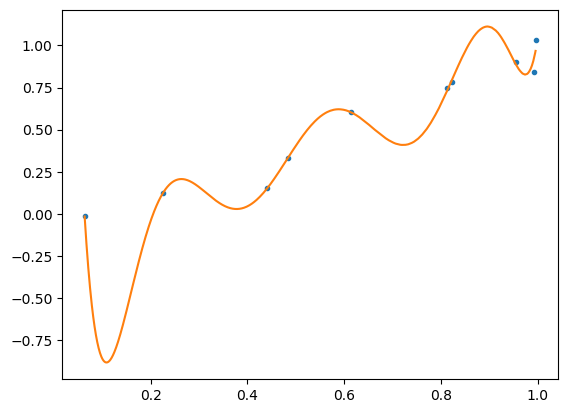

In [21]:
plt.plot(x,y,".")
plt.plot(grid, kr.predict(grid));

There are slight differences due to different implementations and different interpretations of $\lambda$, but they are essentially the same.

### RBF kernel vs. RBF features

Next we'll try to show how the RBF kernel relates to the RBF features. We implement the RBF features (from Lecture 14) below, and compare with the above. 

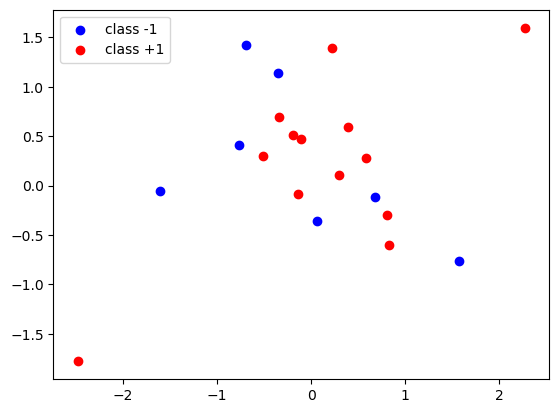

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [23]:
# generate synthetic 2D data set
Random.seed!(0)
n = 20
X = randn(n,2)
y = rand([-1,+1],n)

plt.scatter(X[y.<0,1], X[y.<0,2], color="b", label="class -1")
plt.scatter(X[y.>0,1], X[y.>0,2], color="r", label="class +1")
plt.legend(loc="best")
plt.show()

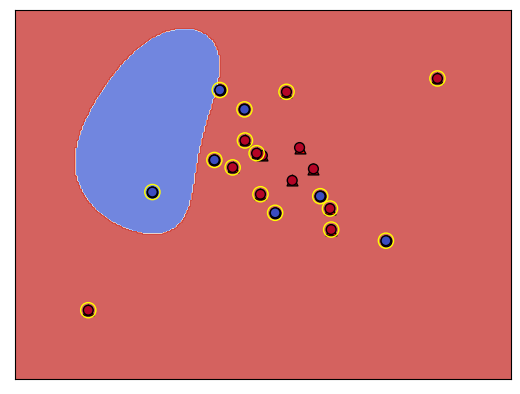

C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [26]:
svm = SkSVM.SVC(kernel="rbf")
svm.fit(X,y)
plot_classifier(X, y, svm,ax=plt.gca())
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);

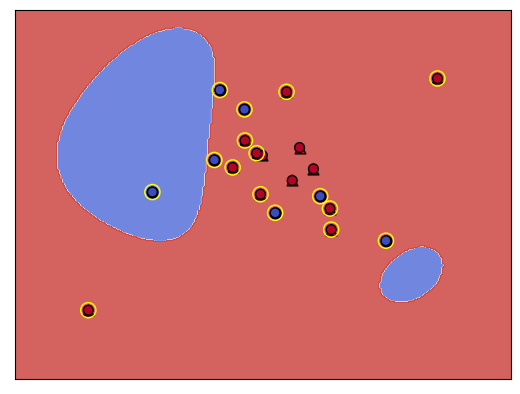

In [38]:
Z = RBF_features(X,X)
svm2 = SkSVM.SVC(kernel="linear")
svm2.fit(Z,y)
plot_classifier(X, y, svm2, transformation=Xtest-> RBF_features(X,Xtest), ax=plt.gca())
plt.scatter(X[svm2.support_.+1,:][:,1],X[svm2.support_.+1,:][:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);

They look pretty similar. Let's time them though. 

In [42]:
n = 1000
d = 10
X = randn(n,d)
y = rand([-1,+1],n)

svm = SkSVM.SVC(kernel="rbf",gamma="scale")

@time svm.fit(X,y);

  0.050502 seconds (26 allocations: 1.203 KiB)


In [43]:
@time svm.predict(X);

  0.027283 seconds (43 allocations: 9.953 KiB)


In [45]:
Z = RBF_features(X,X)
svm2 = SkSVM.SVC(kernel="linear")

@time svm2.fit(Z,y);

  1.095040 seconds (26 allocations: 1.203 KiB)


In [47]:
@time svm2.predict(Z);

  1.101239 seconds (43 allocations: 9.953 KiB)
